## Question 1
### (10 points) Using Kim’s video and reading material set the output you want to |10>. Show your Python code and a screen capture of the results.

In [3]:
# General
import numpy as np

# Plotting routines
import matplotlib.pyplot as plt

# Qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Qiskit Aer imports
from qiskit_aer import AerSimulator, Aer
from qiskit_aer.noise import NoiseModel

# Qiskit Runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2 as Sampler, SamplerOptions

from qiskit.compiler import transpile, assemble
from qiskit.transpiler import PassManager, CouplingMap 

from qiskit.circuit.library import GroverOperator

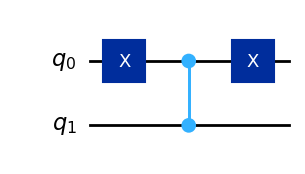

In [2]:
# Step 1: Define the Oracle circuit
oracle = QuantumCircuit(2, name="oracle")

# Step 2: Apply an X gate to qubit 1 to swap |10⟩ <-> |11⟩
oracle.x(0)

# Step 3: Apply a Controlled-Z (CZ) Gate (flips phase of |11⟩, which was originally |10⟩)
oracle.cz(0, 1)

# Step 4: Apply another X gate to revert the transformation
oracle.x(0)

# Step 5: Convert to gate (optional, for modularity)
oracle_gate = oracle.to_gate()

# Step 6: Draw the Oracle circuit
oracle.draw("mpl")

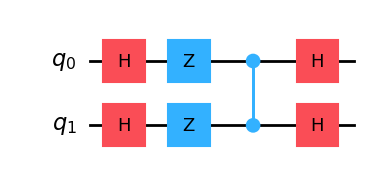

In [3]:
reflection = QuantumCircuit(2, name="reflection")
reflection.h([0,1])
reflection.z([0,1])
reflection.cz(0,1)
reflection.h([0,1])
reflection.to_gate()
reflection.draw("mpl")

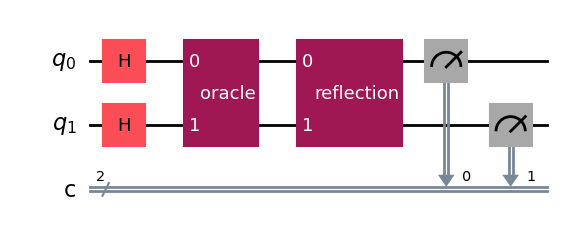

In [4]:
grover_circ = QuantumCircuit(2,2)
grover_circ.h([0,1])
grover_circ.append(oracle,[0,1])
grover_circ.append(reflection,[0,1])
grover_circ.measure([0,1],[0,1])
grover_circ.draw('mpl')

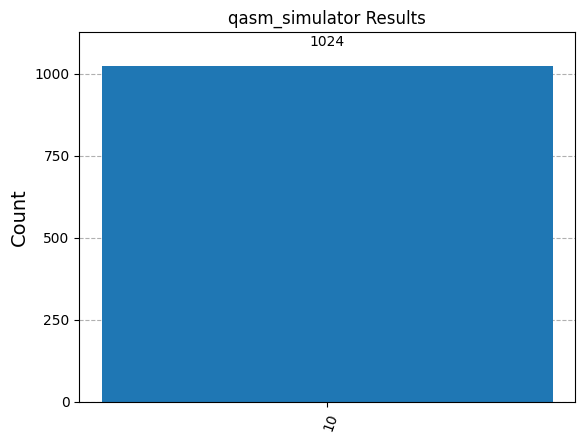

In [5]:
backend = Aer.get_backend("qasm_simulator")
# Simulate the circuit
t_qc = transpile(grover_circ, backend)
# print(t_qc)
result = backend.run(t_qc).result()
# print(result)

counts = result.get_counts()

# plot the results
from qiskit.visualization import plot_histogram
plot_histogram(counts, title="qasm_simulator Results")

## Question 2
### (10 points) Do the same experiment as above (3 qubit looking for ket |101>) but on a real backend and use 1000 shots. Again, show your Python code and screen capture of the results. Everyone should have different results for this, so don’t copy your friends.

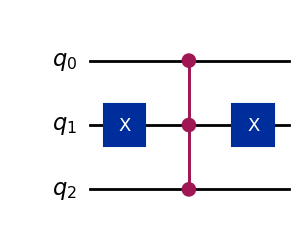

In [2]:
# Step 1: Define the Oracle circuit for |101⟩
oracle = QuantumCircuit(3, name="oracle")  # 3-qubit circuit

# Step 2: Apply X gates to qubits 0 and 2
# This transforms |101⟩ into |111⟩ so that we can apply a CCZ gate.
oracle.x(1) 
# oracle.x(2) 

# Step 3: Apply a Controlled-Controlled-Z (CCZ) gate
# This flips the phase of |111⟩ (originally |101⟩)
oracle.ccz(0, 1, 2)

# Step 4: Undo the X gates to restore original basis
oracle.x(1) 
# oracle.x(2) 

# Step 5: Convert to a gate (optional, for modularity)
#oracle_gate = oracle.to_gate()

# Step 6: Draw the Oracle Circuit
oracle.draw("mpl")

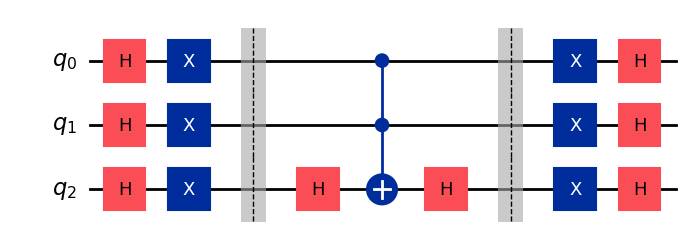

In [7]:
# Step 1: Define the 3-qubit reflection circuit
diffusion = QuantumCircuit(3, name="diffusion")

# Step 2: Apply Hadamard gates to all qubits
diffusion.h([0,1,2])

diffusion.x([0, 1, 2])

diffusion.barrier()

diffusion.h(2)
diffusion.ccx(0, 1, 2)
diffusion.h(2)

diffusion.barrier()

diffusion.x([0, 1, 2])

# Step 5: Apply Hadamard gates again
diffusion.h([0,1,2])

# Step 6: Convert to a gate (for modular use)
# diffusion_gate = diffusion_gate.to_gate()

# Step 7: Draw the Reflection circuit
diffusion.draw("mpl")


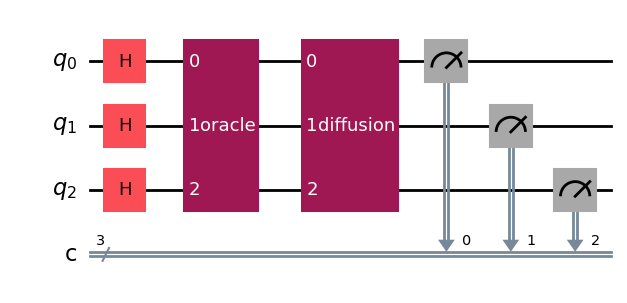

In [8]:
grover_circ = QuantumCircuit(3,3)
grover_circ.h([0,1,2])
grover_circ.append(oracle,[0,1,2])
grover_circ.append(diffusion,[0,1,2])
grover_circ.measure([0,1,2],[0,1,2])
grover_circ.draw('mpl')

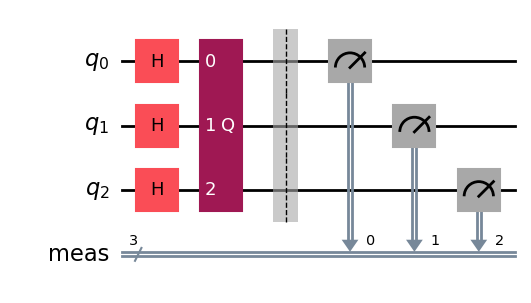

In [3]:
grover_oracle = GroverOperator(oracle)
grover_circ = QuantumCircuit(3)
grover_circ.h([0,1,2])

grover_circ = grover_circ.compose(grover_oracle)

grover_circ.measure_all()
grover_circ.draw('mpl')

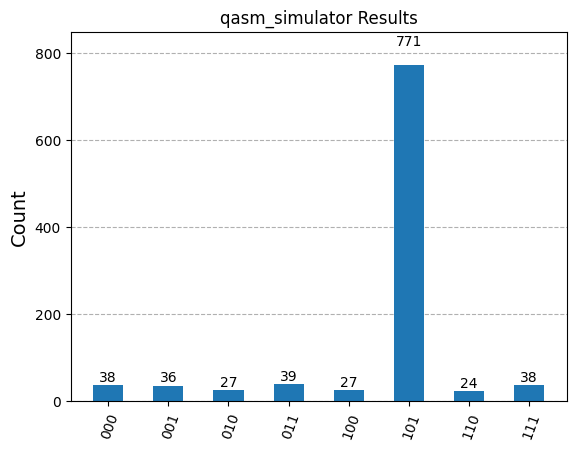

In [4]:
backend = Aer.get_backend("qasm_simulator")
# Simulate the circuit
t_qc = transpile(grover_circ, backend)
# print(t_qc)
result = backend.run(t_qc, shots=1000).result()
# print(result)

counts = result.get_counts()

# plot the results
plot_histogram(counts, title="qasm_simulator Results")

In [7]:
QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    token="9199b5043381bf71eda4b90f02290e9ad349e1467946d68e8d8ae3e1daa35386930d13b21d73403c7b7dc8cd7c8875f648b90cb4e6f1843383edb9bb2c5dde29",
    set_as_default=True,
    # Use `overwrite=True` if you're updating your token.
    overwrite=True,
)

In [8]:
# Load saved credentials
service = QiskitRuntimeService()

In [112]:
import webbrowser
webbrowser.open(f"https://quantum.ibm.com/services/resources?system={backend.name}")

True

In [66]:
print(service.backends())
backend = service.backend('ibm_brisbane')

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_kyiv')>]


In [67]:
noise_model = NoiseModel.from_backend(backend)
noisy_simulator = AerSimulator(noise_model=noise_model)

In [68]:
# Assuming you have a backend reference and a circuit
transpiled_circuit = transpile(grover_circ, backend, optimization_level=3)

{'111': 49, '011': 49, '100': 60, '001': 64, '110': 55, '000': 40, '010': 54, '101': 629}


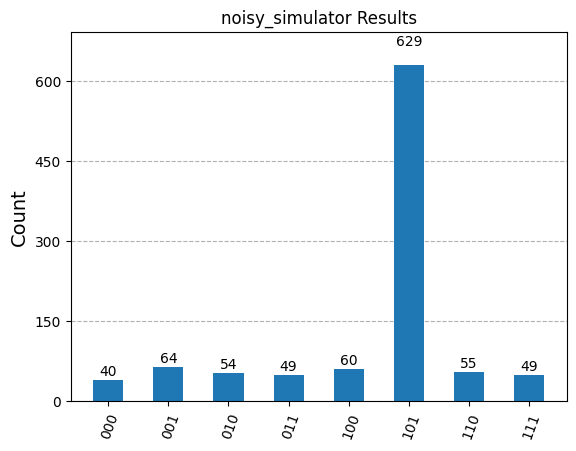

In [69]:
# Run the transpiled circuits on the noisy simulator
job = noisy_simulator.run(transpiled_circuit, shots=1000)
result = job.result()

# Plot the results
counts = result.get_counts(0)
print(counts)
plot_histogram(counts, title="noisy_simulator Results")

In [70]:
pass_manager = generate_preset_pass_manager(
    optimization_level=2,  # Adjust the level as needed (0-3)
    backend=backend
)
print(pass_manager)
transpiled_circuit = pass_manager.run(grover_circ)
print(transpiled_circuit.depth())
num_qubits = transpiled_circuit.num_qubits
print(num_qubits)

88
127


In [90]:
sampler = Sampler(backend)
job = sampler.run([transpiled_circuit]) # Wrap circuit in a list

job_id = job.job_id()

print(f"Job ID: {job_id}")

Job ID: czekaqjqadq0008cytx0


In [113]:
job.status()

'DONE'

BitArray(<shape=(), num_shots=4096, num_bits=3>)


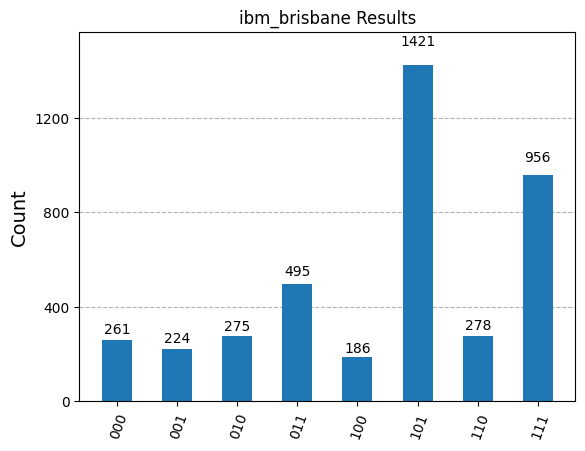

In [114]:
result = job.result()[0]["__value__"]["data"].meas
print(result)
# Plot the results
counts = result.get_counts()
plot_histogram(counts, title="ibm_brisbane Results")

## Question 3
### (10 points) Now use Grover’s Algorithm to solve a 3-SAT problem for the following DIMACS Conjunctive Normal Form (CNF). Read in CNF file, use PhaseOracle in QISKIT to build this as an Oracle. Then use Grover’s algorithm on real quantum computer to solve.

In [1]:
with open('3sat.dimacs', 'r', encoding='utf8') as f:
    dimacs = f.read()
print(dimacs)  # let's check the file is as promised

c example DIMACS-CNF 3-SAT
p cnf 3 5
-1 -2 -3 0
1 -2 3 0
1 2 -3 0
1 -2 -3 0
-1 2 3 0


In [2]:
from qiskit.circuit.library import PhaseOracle
oracle = PhaseOracle.from_dimacs_file('examples/3sat.dimacs')
oracle.draw('mpl')

ImportError: Qiskit is installed in an invalid environment that has both Qiskit >=1.0 and an earlier version. You should create a new virtual environment, and ensure that you do not mix dependencies between Qiskit <1.0 and >=1.0. Any packages that depend on 'qiskit-terra' are not compatible with Qiskit 1.0 and will need to be updated. Qiskit unfortunately cannot enforce this requirement during environment resolution. See https://qisk.it/packaging-1-0 for more detail.

In [6]:
init = QuantumCircuit(3)
init.h([0,1,2])
init.draw("mpl")

NameError: name 'QuantumCircuit' is not defined

In [12]:
grover_operator = GroverOperator(oracle)
qc = init.compose(grover_operator)
qc.measure_all()
qc.draw()

NameError: name 'oracle' is not defined

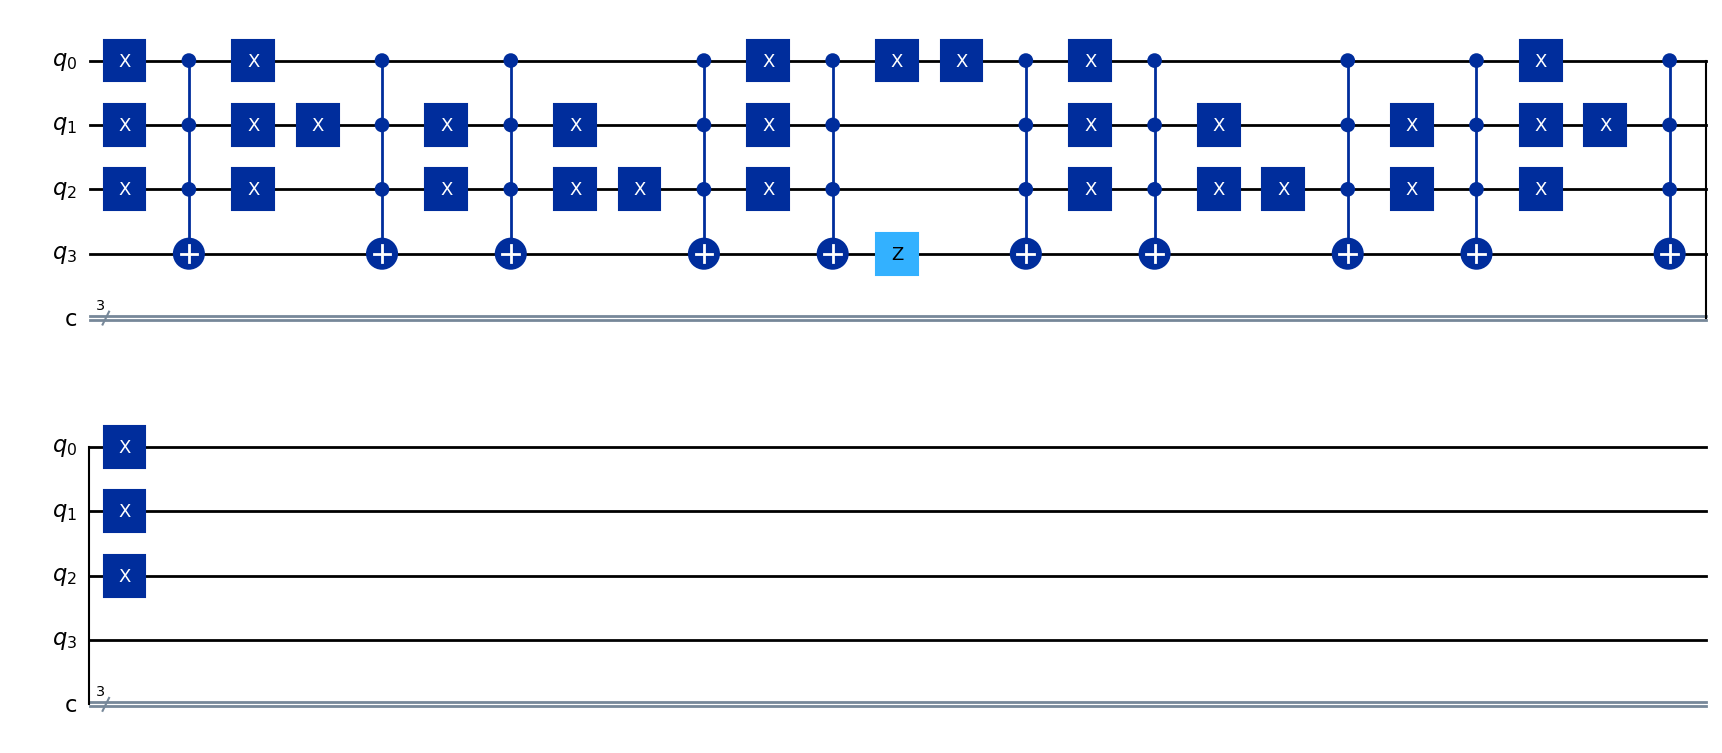

In [7]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import MCXGate

# Define 3 qubits for variables and 1 ancilla for marking
qr = QuantumRegister(4, name="q")  # 3 qubits + 1 ancilla
cr = ClassicalRegister(3, name="c")  # For measurement
qc = QuantumCircuit(qr, cr)

# Encode clauses using multi-controlled Toffoli gates
clauses = [
    (-1, -2, -3),
    (1, -2, 3),
    (1, 2, -3),
    (1, -2, -3),
    (-1, 2, 3)
]

for clause in clauses:
    controls = []
    for var in clause:
        if var > 0:
            controls.append(qr[abs(var) - 1])  # Direct control
        else:
            qc.x(qr[abs(var) - 1])  # Flip for negative literals
            controls.append(qr[abs(var) - 1])

    # Multi-controlled NOT (Toffoli) on the ancilla qubit
    qc.append(MCXGate(len(controls), ctrl_state='1'*len(controls)), controls + [qr[3]])

    # Undo X gates for negative literals
    for var in clause:
        if var < 0:
            qc.x(qr[abs(var) - 1])

# Apply phase flip (Z-gate) on the ancilla if all clauses are satisfied
qc.z(qr[3])

# Uncompute ancilla (reverse the clause encoding)
for clause in reversed(clauses):
    controls = []
    for var in clause:
        if var > 0:
            controls.append(qr[abs(var) - 1])
        else:
            qc.x(qr[abs(var) - 1])
            controls.append(qr[abs(var) - 1])

    qc.append(MCXGate(len(controls), ctrl_state='1'*len(controls)), controls + [qr[3]])

    for var in clause:
        if var < 0:
            qc.x(qr[abs(var) - 1])

# Draw the circuit
qc.draw('mpl')


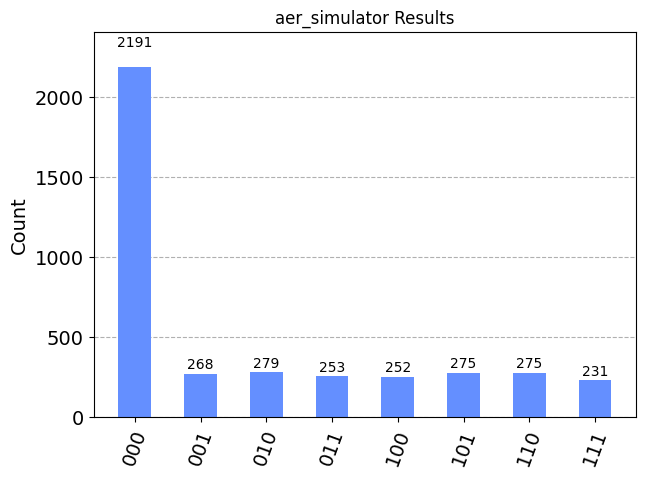

In [33]:
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import MCXGate

# Step 1: Define the Oracle Circuit (Manually Constructed)
qr = QuantumRegister(4, name="q")  # 3 qubits + 1 ancilla
cr = ClassicalRegister(3, name="c")  # For measurement
qc_oracle = QuantumCircuit(qr, cr)

# Encode clauses using multi-controlled Toffoli gates
clauses = [
    (-1, -2, -3),
    (1, -2, 3),
    (1, 2, -3),
    (1, -2, -3),
    (-1, 2, 3)
]

for clause in clauses:
    controls = []
    for var in clause:
        if var > 0:
            controls.append(qr[abs(var) - 1])  # Direct control
        else:
            qc_oracle.x(qr[abs(var) - 1])  # Flip for negative literals
            controls.append(qr[abs(var) - 1])

    # Multi-controlled NOT (Toffoli) on the ancilla qubit
    qc_oracle.append(MCXGate(len(controls), ctrl_state='1'*len(controls)), controls + [qr[3]])

    # Undo X gates for negative literals
    for var in clause:
        if var < 0:
            qc_oracle.x(qr[abs(var) - 1])

# Apply phase flip (Z-gate) on the ancilla if all clauses are satisfied
qc_oracle.z(qr[3])

# Uncompute ancilla (reverse the clause encoding)
for clause in reversed(clauses):
    controls = []
    for var in clause:
        if var > 0:
            controls.append(qr[abs(var) - 1])
        else:
            qc_oracle.x(qr[abs(var) - 1])
            controls.append(qr[abs(var) - 1])

    qc_oracle.append(MCXGate(len(controls), ctrl_state='1'*len(controls)), controls + [qr[3]])

    for var in clause:
        if var < 0:
            qc_oracle.x(qr[abs(var) - 1])

# Step 2: Apply Superposition (Hadamard Initialization)
qc_init = QuantumCircuit(qr, cr)
qc_init.h(range(3))  # Apply Hadamard to first 3 qubits (ignore ancilla)
qc_init.barrier()

# Step 4: Apply Grover's Algorithm (One Iteration)
grover_circ = qc_init.compose(grover_circ)
grover_circ.measure(qr[:3], cr)  # Measure only the first 3 qubits
grover_circ.draw('mpl')

# Step 5: Run on QASM Simulator (Your Requested Format)
backend = Aer.get_backend("aer_simulator")
t_qc = transpile(grover_circ, backend)  # Transpile for the backend
result = backend.run(t_qc, shots=4024).result()  # Run with 1000 shots

# Step 6: Get Results & Plot
counts = result.get_counts()
plot_histogram(counts, title="aer_simulator Results")


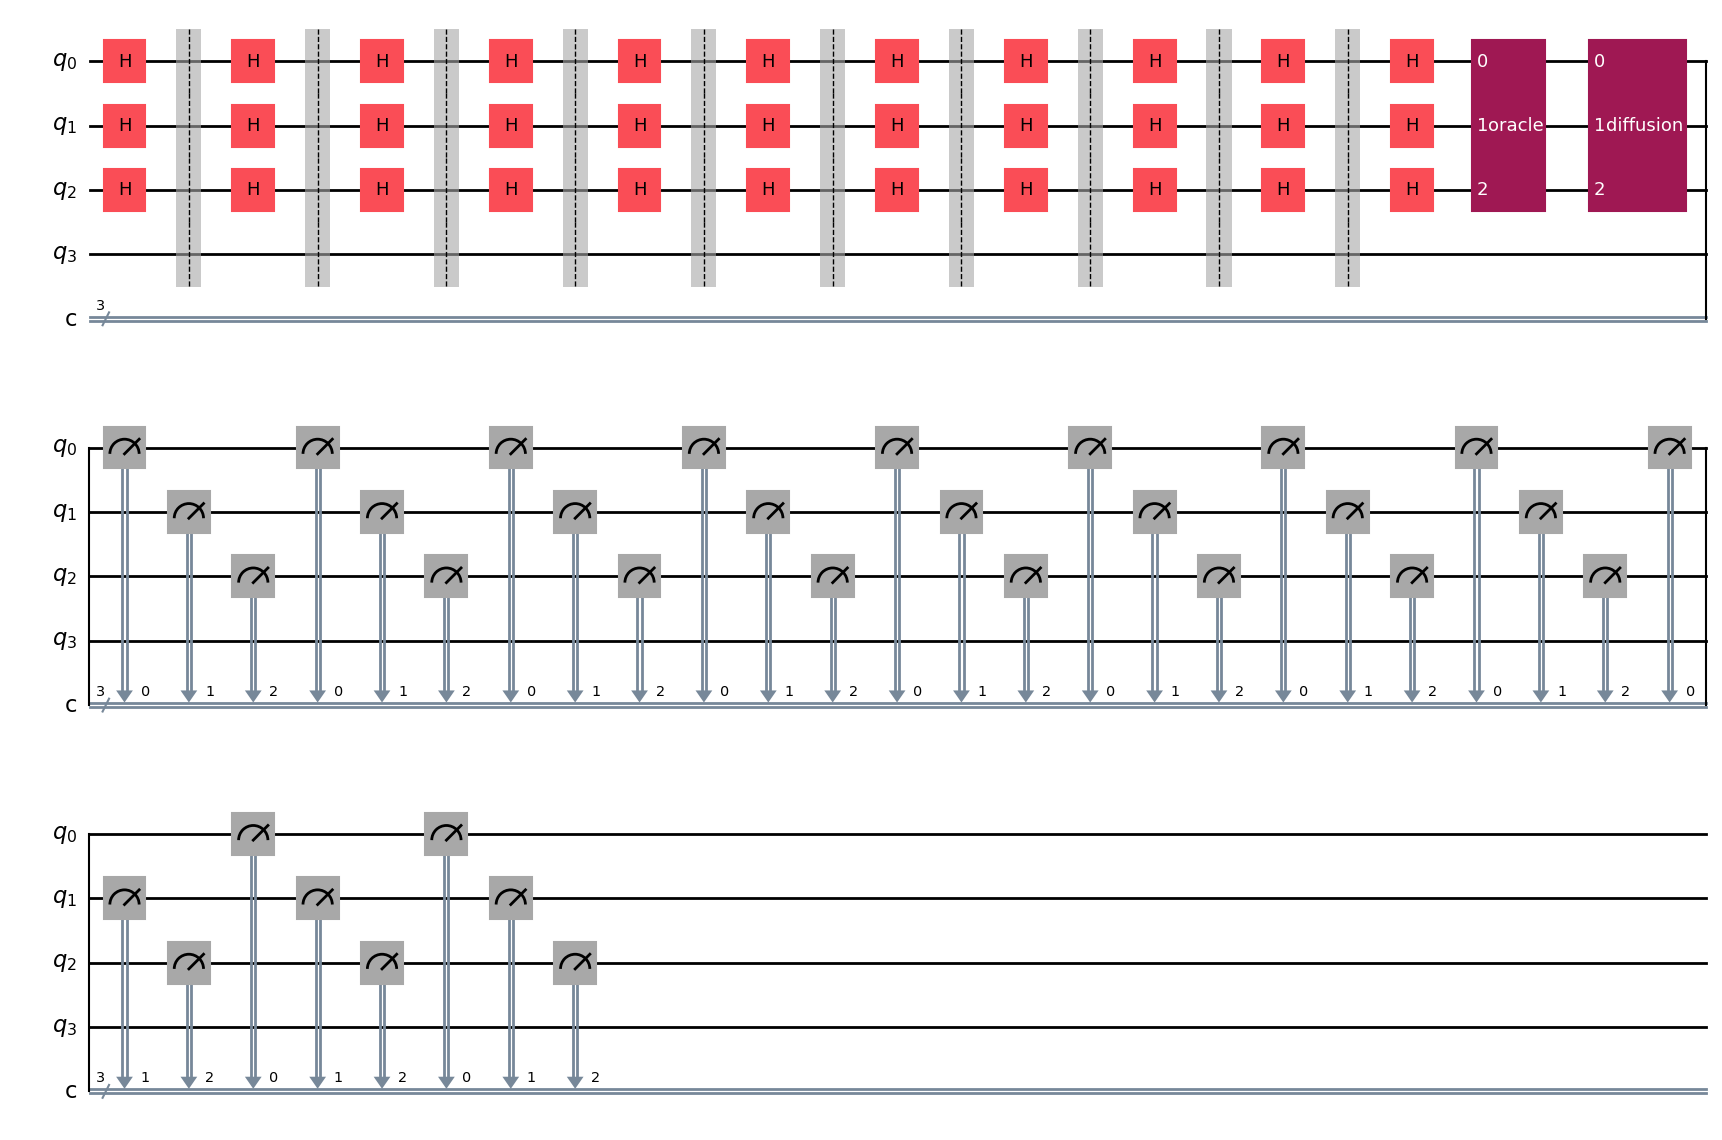

In [37]:
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import MCXGate, GroverOperator

# Step 1: Define the Oracle Circuit (Manually Constructed)
qr = QuantumRegister(4, name="q")  # 3 qubits + 1 ancilla
cr = ClassicalRegister(3, name="c")  # For measurement
qc_oracle = QuantumCircuit(qr, cr)

# Encode clauses using multi-controlled Toffoli gates
clauses = [
    (-1, -2, -3),
    (1, -2, 3),
    (1, 2, -3),
    (1, -2, -3),
    (-1, 2, 3)
]

for clause in clauses:
    controls = []
    for var in clause:
        if var > 0:
            controls.append(qr[abs(var) - 1])  # Direct control
        else:
            qc_oracle.x(qr[abs(var) - 1])  # Flip for negative literals
            controls.append(qr[abs(var) - 1])

    # Multi-controlled NOT (Toffoli) on the ancilla qubit
    qc_oracle.append(MCXGate(len(controls), ctrl_state='1' * len(controls)), controls + [qr[3]])

    # Undo X gates for negative literals
    for var in clause:
        if var < 0:
            qc_oracle.x(qr[abs(var) - 1])

# Apply phase flip (Z-gate) on the ancilla if all clauses are satisfied
qc_oracle.z(qr[3])

# Uncompute ancilla (reverse the clause encoding)
for clause in reversed(clauses):
    controls = []
    for var in clause:
        if var > 0:
            controls.append(qr[abs(var) - 1])
        else:
            qc_oracle.x(qr[abs(var) - 1])
            controls.append(qr[abs(var) - 1])

    qc_oracle.append(MCXGate(len(controls), ctrl_state='1' * len(controls)), controls + [qr[3]])

    for var in clause:
        if var < 0:
            qc_oracle.x(qr[abs(var) - 1])

# Step 2: Apply Superposition (Hadamard Initialization)
qc_init = QuantumCircuit(qr, cr)
qc_init.h(range(3))  # Apply Hadamard to first 3 qubits (ignore ancilla)
qc_init.barrier()


# Step 4: Apply Grover's Algorithm (One Iteration)
grover_circ = qc_init.compose(grover_circ)  # Correct composition
grover_circ.measure(qr[:3], cr)  # Measure only the first 3 qubits
grover_circ.draw('mpl')



In [56]:
from qiskit import QuantumCircuit

# Create a quantum circuit with 3 qubits (no extra qubits)
oracle = QuantumCircuit(3, name='3-SAT Oracle')

# Clause (-1, -2, -3) → X on all, then CCZ
oracle.x([0, 1, 2])  
oracle.h(2)
oracle.ccx(0, 1, 2)
oracle.h(2)
oracle.x([0, 1, 2])  

# Clause (1, -2, 3) → X on q1 only, then CCZ
oracle.x(1)
oracle.h(2)
oracle.ccx(0, 1, 2)
oracle.h(2)
oracle.x(1)

# Clause (1, 2, -3) → X on q2 only, then CCZ
oracle.x(2)
oracle.h(2)
oracle.ccx(0, 1, 2)
oracle.h(2)
oracle.x(2)

# Clause (1, -2, -3) → X on q1 and q2, then CCZ
oracle.x([1, 2])
oracle.h(2)
oracle.ccx(0, 1, 2)
oracle.h(2)
oracle.x([1, 2])

# Clause (-1, 2, 3) → X on q0 only, then CCZ
oracle.x(0)
oracle.h(2)
oracle.ccx(0, 1, 2)
oracle.h(2)
oracle.x(0)

# Draw the final oracle circuit
display(oracle.draw())


┌───┐          ┌───┐                                                  »
q_0: ┤ X ├───────■──┤ X ├────────────■───────────────────■─────────────────»
     ├───┤       │  ├───┤┌───┐       │  ┌───┐            │  ┌───┐          »
q_1: ┤ X ├───────■──┤ X ├┤ X ├───────■──┤ X ├────────────■──┤ X ├──────────»
     ├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐┌─┴─┐├───┤┌───┐┌───┐┌─┴─┐├───┤┌───┐┌───┐»
q_2: ┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ X ├»
     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
«               ┌───┐               ┌───┐
«q_0: ───────■──┤ X ├────────────■──┤ X ├
«            │  ├───┤            │  └───┘
«q_1: ───────■──┤ X ├────────────■───────
«     ┌───┐┌─┴─┐├───┤┌───┐┌───┐┌─┴─┐┌───┐
«q_2: ┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├
«     └───┘└───┘└───┘└───┘└───┘└───┘└───┘

In [57]:
init = QuantumCircuit(3)
init.h([0,1,2])
init.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     └───┘

In [58]:
# steps 2 & 3 of Grover's algorithm
from qiskit.circuit.library import GroverOperator
grover_operator = GroverOperator(oracle)
grover_operator.draw()

┌────┐
state_0: ┤0   ├
         │    │
state_1: ┤1 Q ├
         │    │
state_2: ┤2   ├
         └────┘

In [59]:
qc = init.compose(grover_operator)
qc.measure_all()
qc.draw()

┌───┐┌────┐ ░ ┌─┐      
   q_0: ┤ H ├┤0   ├─░─┤M├──────
        ├───┤│    │ ░ └╥┘┌─┐   
   q_1: ┤ H ├┤1 Q ├─░──╫─┤M├───
        ├───┤│    │ ░  ║ └╥┘┌─┐
   q_2: ┤ H ├┤2   ├─░──╫──╫─┤M├
        └───┘└────┘ ░  ║  ║ └╥┘
meas: 3/═══════════════╩══╩══╩═
                       0  1  2

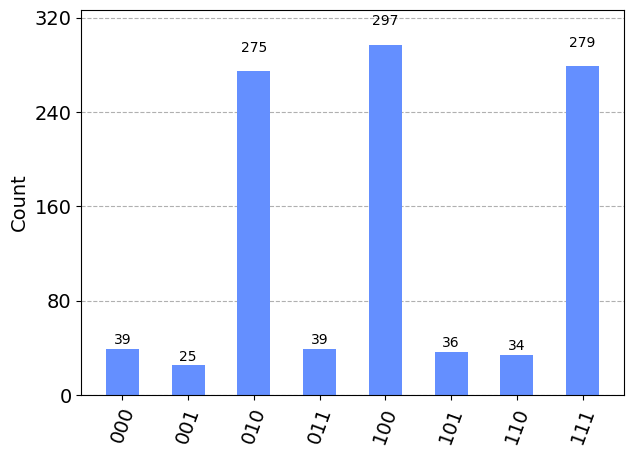

In [62]:
# Simulate the circuit
sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, sim)
counts = sim.run(t_qc).result().get_counts()

# plot the results
from qiskit.visualization import plot_histogram
plot_histogram(counts)

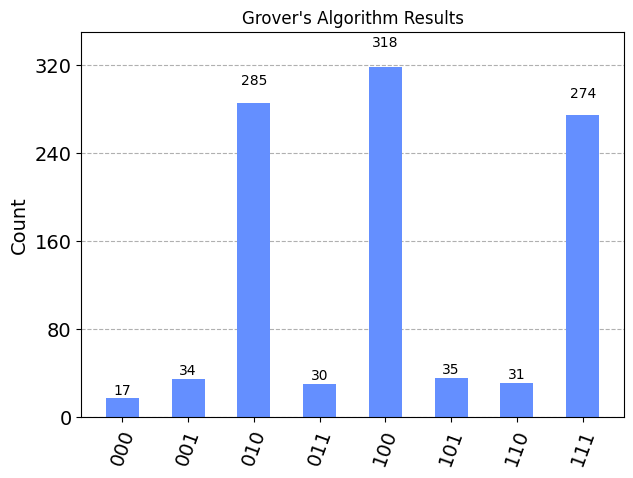

In [67]:

def create_3sat_oracle(clauses):
    """Creates a 3-SAT oracle QuantumCircuit for the given clauses."""
    num_variables = 3  # Based on the problem description
    oracle = QuantumCircuit(num_variables, name='3-SAT Oracle')

    for clause in clauses:
        for i, literal in enumerate(clause):
            if literal < 0:
                oracle.x(abs(literal) - 1)

        oracle.h(2)
        oracle.ccx(0, 1, 2)
        oracle.h(2)

        for i, literal in enumerate(clause):
            if literal < 0:
                oracle.x(abs(literal) - 1)

    return oracle

# Provided 3-SAT problem clauses
clauses = [
    (-1, -2, -3),
    (1, -2, 3),
    (1, 2, -3),
    (1, -2, -3),
    (-1, 2, 3),
]

# Create the oracle circuit
oracle = create_3sat_oracle(clauses)

# Step 2: Apply Superposition (Hadamard Initialization)
grover_circ = QuantumCircuit(3, 3)
grover_circ.h([0, 1, 2])  # Apply Hadamard to all qubits

# Step 3: Construct Grover's Operator
grover_operator = GroverOperator(oracle)

# Step 4: Apply Grover's Algorithm (One Iteration)
grover_circ.compose(grover_operator, inplace=True)
grover_circ.measure([0, 1, 2], [0, 1, 2])  # Measure all qubits

# Step 5: Run on QASM Simulator
backend = Aer.get_backend("aer_simulator")
t_qc = transpile(grover_circ, backend)
result = backend.run(t_qc, shots=1024).result()

# Step 6: Get Results & Plot
counts = result.get_counts()
plot_histogram(counts, title="Grover's Algorithm Results")

In [2]:

def create_3sat_oracle(clauses):
    """Creates a 3-SAT oracle QuantumCircuit for the given clauses."""
    num_variables = 3  # Given problem has 3 variables
    oracle = QuantumCircuit(num_variables, name='3-SAT Oracle')

    for clause in clauses:
        # Apply X gates to negate literals as needed
        for literal in clause:
            if literal < 0:
                oracle.x(abs(literal) - 1)  # Flip for negated literals

        # Apply CCZ (multi-controlled Z gate) to mark satisfying states
        oracle.h(2)  # Convert Z-basis to X-basis
        oracle.ccx(0, 1, 2)
        oracle.h(2)

        # Undo the X gates
        for literal in clause:
            if literal < 0:
                oracle.x(abs(literal) - 1)

    return oracle

# Given 3-SAT problem in DIMACS format
clauses = [
    (-1, -2, -3),
    (1, -2, 3),
    (1, 2, -3),
    (1, -2, -3),
    (-1, 2, 3),
]

# Step 1: Create the correct 3-SAT Oracle
oracle = create_3sat_oracle(clauses)

# Step 2: Initialize the quantum circuit for Grover's algorithm
grover_circ = QuantumCircuit(3, 3)
grover_circ.h([0, 1, 2])  # Apply Hadamard to all qubits

# Step 3: Construct the Grover operator
grover_operator = GroverOperator(oracle)

# Step 4: Apply Grover's algorithm (One Iteration)
grover_circ.compose(grover_operator, inplace=True)
grover_circ.measure([0, 1, 2], [0, 1, 2])  # Measure all qubits

# Step 5: Run on QASM Simulator
backend = Aer.get_backend("aer_simulator")
t_qc = transpile(grover_circ, backend)
result = backend.run(t_qc, shots=1024).result()

# Step 6: Get Results & Plot
counts = result.get_counts()
plot_histogram(counts, title="Grover's Algorithm Results")


NameError: name 'QuantumCircuit' is not defined

In [1]:

def create_3sat_oracle(clauses):
    """Creates a 3-SAT oracle QuantumCircuit for the given clauses."""
    num_variables = 3  # Given problem has 3 variables
    oracle = QuantumCircuit(num_variables, name='3-SAT Oracle')

    for clause in clauses:
        # Apply X gates to negate literals as needed
        for literal in clause:
            if literal < 0:
                oracle.x(abs(literal) - 1)  # Flip for negated literals

        # Apply CCZ (multi-controlled Z gate) to mark satisfying states
        oracle.h(2)  # Convert Z-basis to X-basis
        oracle.ccx(0, 1, 2)  # Apply CCX (Toffoli) gate
        oracle.h(2)  # Convert back to Z-basis

        # Undo the X gates
        for literal in clause:
            if literal < 0:
                oracle.x(abs(literal) - 1)

    return oracle

# Given 3-SAT problem in DIMACS format
clauses = [
    (-1, -2, -3),
    (1, -2, 3),
    (1, 2, -3),
    (1, -2, -3),
    (-1, 2, 3),
]

# Step 1: Create the correct 3-SAT Oracle
oracle = create_3sat_oracle(clauses)

# Step 2: Initialize the quantum circuit for Grover's algorithm
grover_circ = QuantumCircuit(3, 3)
grover_circ.h([0, 1, 2])  # Apply Hadamard to all qubits

# Step 3: Construct the Grover operator
grover_operator = GroverOperator(oracle)

# Step 4: Apply Grover's algorithm (One Iteration)
grover_circ.compose(grover_operator, inplace=True)
grover_circ.measure([0, 1, 2], [0, 1, 2])  # Measure all qubits

# Step 5: Run on QASM Simulator
backend = Aer.get_backend("aer_simulator")
t_qc = transpile(grover_circ, backend)
result = backend.run(t_qc, shots=1024).result()

# Step 6: Get Results & Plot
counts = result.get_counts()
plot_histogram(counts, title="Grover's Algorithm Results")

NameError: name 'QuantumCircuit' is not defined

# 3-SAT - grover-intro - Reference  
https://github.com/Qiskit/textbook/blob/main/notebooks/intro/grover-intro.ipynb 

Solution:
c example DIMACS-CNF 3-SAT
p cnf 3 5
-1 -2 -3 0
1 -2 3 0
1 2 -3 0
1 -2 -3 0
-1 2 3 0

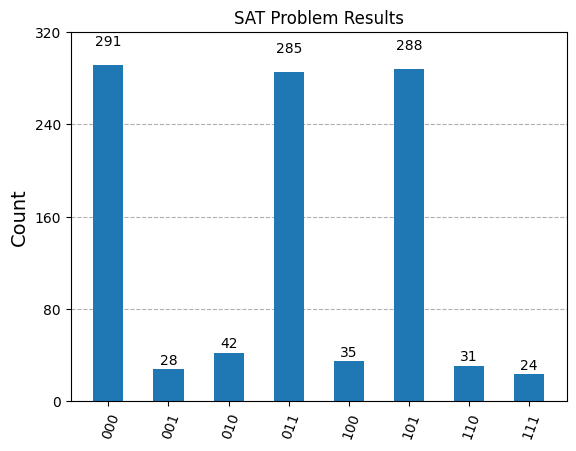

In [4]:

def create_3sat_oracle(clauses):
    """Creates a 3-SAT oracle QuantumCircuit for the given clauses."""
    num_variables = 3  # Given problem has 3 variables
    oracle = QuantumCircuit(num_variables, name='3-SAT Oracle')

    for clause in clauses:
        # Apply X gates to negate literals as needed
        for literal in clause:
            if literal < 0:
                oracle.x(abs(literal) - 1)  # Flip for negated literals

        # Apply CCZ (multi-controlled Z gate) to mark satisfying states
        oracle.h(2)  # Convert Z-basis to X-basis
        oracle.ccx(0, 1, 2)  # Apply CCX (Toffoli) gate
        oracle.h(2)  # Convert back to Z-basis

        # Undo the X gates
        for literal in clause:
            if literal < 0:
                oracle.x(abs(literal) - 1)

    return oracle

# Given 3-SAT problem in DIMACS format
clauses = [
    (-1, -2, -3),
    (1, -2, 3),
    (1, 2, -3),
    (1, -2, -3),
    (-1, 2, 3),
]

# Step 1: Create the correct 3-SAT Oracle
oracle = create_3sat_oracle(clauses)

# Step 2: Initialize the quantum circuit for Grover's algorithm
grover_circ = QuantumCircuit(3, 3)
grover_circ.h([0, 1, 2])  # Apply Hadamard to all qubits

# Step 3: Construct the Grover operator
grover_operator = GroverOperator(oracle)

# Step 4: Apply Grover's algorithm (One Iteration)
grover_circ.compose(grover_operator, inplace=True)

# Step 5: Add NOT gates to flip the result
grover_circ.x([0, 1, 2])  # Apply X gates to all qubits

# Step 6: Measure all qubits
grover_circ.measure([0, 1, 2], [0, 1, 2])

# Step 7: Run on QASM Simulator
backend = Aer.get_backend("aer_simulator")
t_qc = transpile(grover_circ, backend)
result = backend.run(t_qc, shots=1024).result()

# Step 8: Get Results & Plot
counts = result.get_counts()
plot_histogram(counts, title="SAT Problem Results")

# 3-SAT changed Value
(10 points) Now use Grover’s Algorithm to solve a 3-SAT problem for the following DIMACS
Conjunctive Normal Form (CNF). Read in CNF file, use PhaseOracle in QISKIT to build this as
an Oracle. Then use Grover’s algorithm on real quantum computer to solve. (Note this is
different than “Example 3-SAT Problem” on QISKIT
https://github.com/Qiskit/textbook/blob/main/notebooks/intro/grover-intro.ipynb with
two changes shown in yellow)
Solution:
c example DIMACS-CNF 3-SAT
p cnf 3 5
-1 -2 -3 0
1 -2 3 0
-1 2 -3 0
1 -2 -3 0
-1 -2 3 0

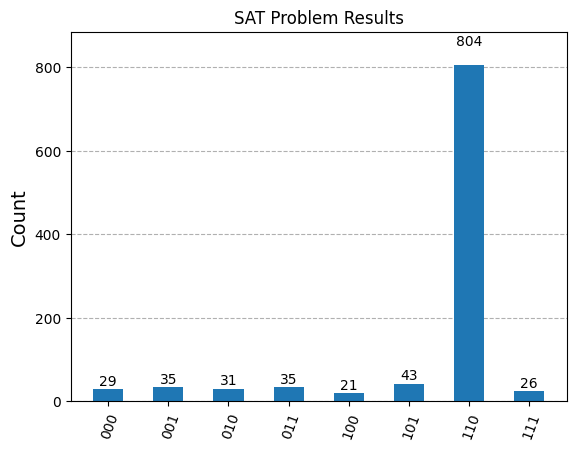

In [4]:

def create_3sat_oracle(clauses):
    """Creates a 3-SAT oracle QuantumCircuit for the given clauses."""
    num_variables = 3  # Given problem has 3 variables
    oracle = QuantumCircuit(num_variables, name='3-SAT Oracle')

    for clause in clauses:
        # Apply X gates to negate literals as needed
        for literal in clause:
            if literal < 0:
                oracle.x(abs(literal) - 1)  # Flip for negated literals

        # Apply CCZ (multi-controlled Z gate) to mark satisfying states
        oracle.h(2)  # Convert Z-basis to X-basis
        oracle.ccx(0, 1, 2)  # Apply CCX (Toffoli) gate
        oracle.h(2)  # Convert back to Z-basis

        # Undo the X gates
        for literal in clause:
            if literal < 0:
                oracle.x(abs(literal) - 1)

    return oracle

# Given 3-SAT problem in DIMACS format
clauses = [
    (1, -2, -3),
    # (1, -2, 3),
    # (-1, 2, -3),
    # (1, -2, -3),
    # (-1, -2, 3),
]

# Step 1: Create the correct 3-SAT Oracle
oracle = create_3sat_oracle(clauses)

# Step 2: Initialize the quantum circuit for Grover's algorithm
grover_circ = QuantumCircuit(3, 3)
grover_circ.h([0, 1, 2])  # Apply Hadamard to all qubits

# Step 3: Construct the Grover operator
grover_operator = GroverOperator(oracle)

# Step 4: Apply Grover's algorithm (One Iteration)
grover_circ.compose(grover_operator, inplace=True)

# Step 5: Add NOT gates to flip the result
grover_circ.x([0, 1, 2])  # Apply X gates to all qubits

# Step 6: Measure all qubits
grover_circ.measure([0, 1, 2], [0, 1, 2])

# Step 7: Run on QASM Simulator
backend = Aer.get_backend("aer_simulator")
t_qc = transpile(grover_circ, backend)
result = backend.run(t_qc, shots=1024).result()

# Step 8: Get Results & Plot
counts = result.get_counts()
plot_histogram(counts, title="SAT Problem Results")

In [6]:

def create_3sat_oracle(clauses):
    """Creates a 3-SAT oracle QuantumCircuit for the given clauses."""
    num_variables = 3  # Given problem has 3 variables
    oracle = QuantumCircuit(num_variables, name='3-SAT Oracle')

    for clause in clauses:
        # Apply X gates to negate literals as needed
        for literal in clause:
            if literal < 0:
                oracle.x(abs(literal) - 1)  # Flip for negated literals

        # Apply CCZ (multi-controlled Z gate) to mark satisfying states
        oracle.h(2)  # Convert Z-basis to X-basis
        oracle.ccx(0, 1, 2)  # Apply CCX (Toffoli) gate
        oracle.h(2)  # Convert back to Z-basis

        # Undo the X gates
        for literal in clause:
            if literal < 0:
                oracle.x(abs(literal) - 1)

    return oracle

# Given 3-SAT problem in DIMACS format
clauses = [
    (-1, -2, -3),
    (1, -2, 3),
    (-1, 2, -3),
    (1, -2, -3),
    (-1, -2, 3),
]

# Step 1: Create the correct 3-SAT Oracle
oracle = create_3sat_oracle(clauses)


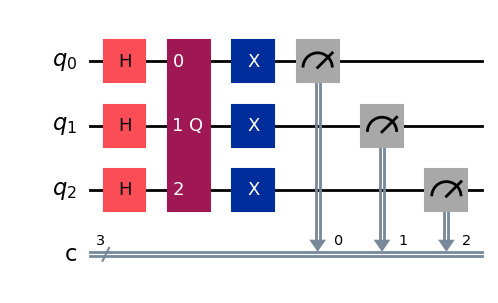

In [7]:

# Step 2: Initialize the quantum circuit for Grover's algorithm
grover_circ = QuantumCircuit(3, 3)
grover_circ.h([0, 1, 2])  # Apply Hadamard to all qubits

# Step 3: Construct the Grover operator
grover_operator = GroverOperator(oracle)

# Step 4: Apply Grover's algorithm (One Iteration)
grover_circ.compose(grover_operator, inplace=True)

# Step 5: Add NOT gates to flip the result
grover_circ.x([0, 1, 2])  # Apply X gates to all qubits

# Step 6: Measure all qubits
grover_circ.measure([0, 1, 2], [0, 1, 2])


grover_circ.draw('mpl')

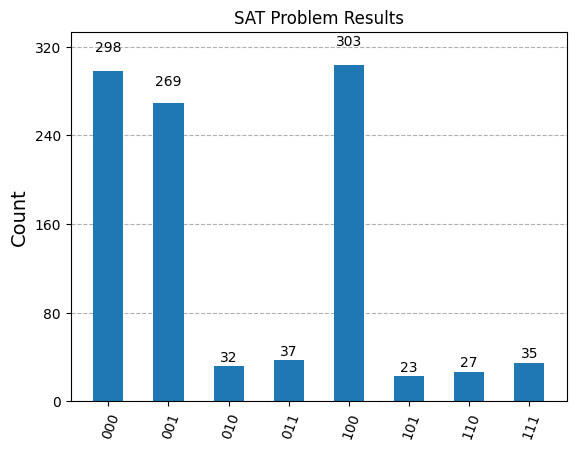

In [8]:

# Step 7: Run on QASM Simulator
backend = Aer.get_backend("aer_simulator")
t_qc = transpile(grover_circ, backend)
result = backend.run(t_qc, shots=1024).result()

# Step 8: Get Results & Plot
counts = result.get_counts()
plot_histogram(counts, title="SAT Problem Results")

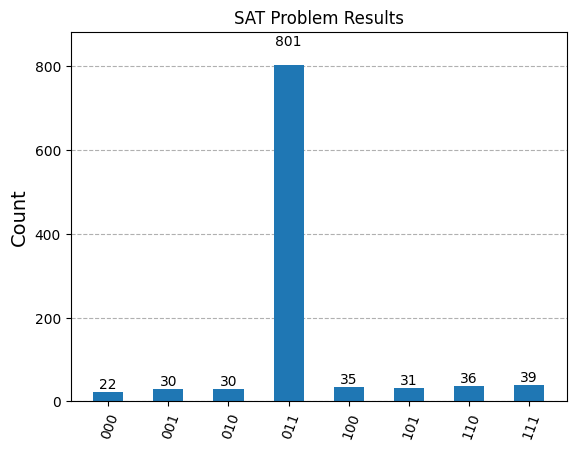

In [19]:

def create_3sat_oracle(clauses):
    """Creates a 3-SAT oracle QuantumCircuit for the given clauses."""
    num_variables = 3  # Given problem has 3 variables
    oracle = QuantumCircuit(num_variables, name='3-SAT Oracle')

    for clause in clauses:
        # Apply X gates to negate literals as needed
        for literal in clause:
            if literal < 0:
                oracle.x(abs(literal) - 1)  # Flip for negated literals

        # Apply CCZ (multi-controlled Z gate) to mark satisfying states
        oracle.h(2)  # Convert Z-basis to X-basis
        oracle.ccx(0, 1, 2)  # Apply CCX (Toffoli) gate
        oracle.h(2)  # Convert back to Z-basis

        # Undo the X gates
        for literal in clause:
            if literal < 0:
                oracle.x(abs(literal) - 1)

    return oracle

# Given 3-SAT problem in DIMACS format
clauses = [
    (-1, -2, 3),
    # (-1, -2, 3),
    # (1, 2, -3),
    # (1, -2, -3),
    # (1, 2, 3),
]

# Step 1: Create the correct 3-SAT Oracle
oracle = create_3sat_oracle(clauses)

# Step 2: Initialize the quantum circuit for Grover's algorithm
grover_circ = QuantumCircuit(3, 3)
grover_circ.h([0, 1, 2])  # Apply Hadamard to all qubits

# Step 3: Construct the Grover operator
grover_operator = GroverOperator(oracle)

# Step 4: Apply Grover's algorithm (One Iteration)
grover_circ.compose(grover_operator, inplace=True)

# Step 5: Add NOT gates to flip the result
grover_circ.x([0, 1, 2])  # Apply X gates to all qubits

# Step 6: Measure all qubits
grover_circ.measure([0, 1, 2], [0, 1, 2])

# Step 7: Run on QASM Simulator
backend = Aer.get_backend("aer_simulator")
t_qc = transpile(grover_circ, backend)
result = backend.run(t_qc, shots=1024).result()

# Step 8: Get Results & Plot
counts = result.get_counts()
plot_histogram(counts, title="SAT Problem Results")

In [16]:
def xor_bits(a, b):
    return a ^ b

def verify_s(s, inputs, outputs):
    n = len(inputs)
    output_lookup = {inputs[i]: outputs[i] for i in range(n)}
    
    for x in inputs:
        x_s = xor_bits(x, s)
        if x_s in output_lookup:
            if output_lookup[x] != output_lookup[x_s]:
                return False
    return True

# === Given data ===
# Inputs
inputs = [
    int('000', 2),
    int('001', 2),
    int('010', 2),
    int('011', 2),
    int('100', 2),
    int('101', 2),
    int('110', 2),
    int('111', 2)
]

# Outputs
outputs = [
    int('000', 2),
    int('010', 2),
    int('001', 2),
    int('011', 2),
    int('011', 2),
    int('101', 2),
    int('111', 2),
    int('110', 2)
]

# === Try all possible s values ===
for s in range(8):  # 3-bit s, so 0 to 7
    if verify_s(s, inputs, outputs):
        print("Hidden s =", format(s, '03b'))
        break


Hidden s = 000
